## Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [4]:
os.chdir("drive/MyDrive/Colab Notebooks/research/meta_learning") 

In [6]:
import csv
import numpy as np
import pandas as pd

In [20]:
data = pd.read_csv('eln.csv')

In [21]:
data = data.dropna(axis=0)

In [22]:
data

,identifiers[0].value,identifiers[1].value,"inputs[""Base""].components[0].identifiers[0].value","inputs[""Base""].components[0].amount.moles.value","inputs[""aryl halide""].components[0].identifiers[0].value","inputs[""aryl halide""].components[0].amount.moles.value","inputs[""amine""].components[0].identifiers[0].value","inputs[""amine""].components[0].amount.moles.value","inputs[""metal and ligand""].components[0].identifiers[0].value","inputs[""metal and ligand""].components[0].amount.moles.value",...,reaction_id,"inputs[""Solvent""].components[0].identifiers[0].type","inputs[""Solvent""].components[0].identifiers[0].value","inputs[""Solvent""].components[0].amount.volume.value","inputs[""Solvent""].components[0].amount.volume.units","inputs[""Solvent""].components[0].reaction_role","inputs[""Solvent""].components[0].is_limiting","inputs[""metal and ligand""].components[0].is_limiting","inputs[""metal and ligand""].components[1].is_limiting","inputs[""Base""].components[0].is_limiting"
1,1,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,C(=O)([O-])[O-].[Cs+].[Cs+],0.019000,C1=CC=C(C=C1)I,0.009140,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,0.00762,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,0.000762,...,ord-1169cbe9fa064a879ac34b2e524a4e69,SMILES,COC1=CC=CC=C1,0.0332,LITER,SOLVENT,False,False,False,False
2,3,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,C(=O)([O-])[O-].[Cs+].[Cs+],0.016800,C1=CC=C(C=C1)I,0.008060,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,0.00672,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,0.000672,...,ord-13992005c22d4673aa802b5e140076e8,SMILES,COC1=CC=CC=C1,0.0149,LITER,SOLVENT,False,False,False,False
3,4,1.3.4 [N-arylation with Ar-X] Iodo Buchwald-Ha...,C(=O)([O-])[O-].[Cs+].[Cs+],0.016800,C1=CC=C(C=C1)I,0.008060,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,0.00672,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,0.000672,...,ord-a36b48917c9942d1a34637511773ee1f,SMILES,COC1=CC=CC=C1,0.0298,LITER,SOLVENT,False,False,False,False
4,7,0.0 [Unassigned] Unrecognized,C(=O)([O-])[O-].[Cs+].[Cs+],0.002760,CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C,0.027600,C1=CC(=CC=C1N)S(=O)(=O)N,0.03580,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,0.002760,...,ord-5fc624fd97b7430eafbe8dcc049d170b,SMILES,CC(=O)N(C)C,0.1300,LITER,SOLVENT,False,False,False,False
5,8,0.0 [Unassigned] Unrecognized,C(=O)([O-])[O-].[Cs+].[Cs+],0.004260,CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C,0.042600,C1=CC(=CC=C1N)S(=O)(=O)N,0.05540,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,0.004260,...,ord-c34e3f2a76e4462999414a169b276944,SMILES,CC(=O)N(C)C,0.2000,LITER,SOLVENT,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,989,1.3.1 [N-arylation with Ar-X] Bromo Buchwald-H...,CC(C)(C)[O-].[Na+],0.000956,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)N4C=NC...,0.000683,C1CNCCN1,0.00410,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,0.000041,...,ord-2d4ae739f81c45c1ab0faf1d764941ef,SMILES,CC1=CC=CC=C1,0.0050,LITER,SOLVENT,False,False,False,False
746,992,1.3.1 [N-arylation with Ar-X] Bromo Buchwald-H...,CC(C)(C)[O-].[Na+],0.005020,C1=CC(=C(C=C1C(F)(F)F)Br)F,0.004180,CC(C)(C)OC(=O)N1CCNCC1,0.00418,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,0.000418,...,ord-370c3c2e243949c9a11cec4ffc24deb1,SMILES,CC1=CC=CC=C1,0.0300,LITER,SOLVENT,False,False,False,False
747,993,1.3.2 [N-arylation with Ar-X] Chloro Buchwald-...,CC(C)(C)[O-].[Na+],0.017000,C1=CN=C(C=C1C(F)(F)F)Cl,0.014200,CC(C)(C)OC(=O)N1CCNCC1,0.01420,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,0.001420,...,ord-416cbc87161d4f439cd1f72049cd3191,SMILES,CC1=CC=CC=C1,0.0300,LITER,SOLVENT,False,False,False,False
748,996,0.0 [Unassigned] Unrecognized,C(=O)([O-])[O-].[Cs+].[Cs+],0.008090,C1=CC2=C(C=CC(=C2N=C1)OS(=O)(=O)C(F)(F)F)Cl,0.005780,CC(C)(C)OC(=O)N1CCNCC1,0.00693,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,0.000289,...,ord-8b2355aecdcf48e08035fb224a453205,SMILES,C1CCOC1,0.0300,LITER,SOLVENT,False,False,False,False


## mordred

In [23]:
!pip install mordred

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 5.0 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=ac0785a655f653e61e3ef6cb3d306b39c5092ca841cc919f11d7afa72ed742cb
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


In [25]:
!pip install --pre deepchem
!pip install rdkit-pypi
import rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 686 kB 5.1 MB/s 
     |████████████████████████████████| 36.8 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pandas as pd
import numpy as np
import mordred
from rdkit import Chem
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors

In [31]:
def mordred(data,name):
  df = data[[name]]
  # make rdkit mols
  df['rdmol'] = df[name].map(lambda x: Chem.MolFromSmiles(x))
  # drop molecules that rdkit cannot handle
  df= df.dropna(subset=['rdmol'])
  # get inchi
  df['inchi'] = df['rdmol'].map(Chem.MolToInchi)
  # drop duplicates on inchi
  df = df.drop_duplicates(subset="inchi")

  df['rdmolH'] = df['rdmol'].map(Chem.AddHs)
  _ = df['rdmolH'].map(AllChem.EmbedMolecule)
  _ = df['rdmolH'].map(AllChem.MMFFOptimizeMolecule)

  # initialize Mordred calculators
  calc=Calculator(descriptors, ignore_3D=True,)
  # compute Mordred descriptors for all molecules (may take long)
  md=calc.pandas(df['rdmol'])

  return pd.concat([df[[name]],md],axis=1) 

## ELN data preprocessing

In [27]:
data_eln = data[['inputs["metal and ligand"].components[0].identifiers[0].value','inputs["amine"].components[0].identifiers[0].value','inputs["aryl halide"].components[0].identifiers[0].value','inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value'#
              ,'outcomes[0].products[0].measurements[0].percentage.value'
         ]].reset_index()
del data_eln['index']

In [28]:
data_eln

,"inputs[""metal and ligand""].components[0].identifiers[0].value","inputs[""amine""].components[0].identifiers[0].value","inputs[""aryl halide""].components[0].identifiers[0].value","inputs[""Base""].components[0].identifiers[0].value","inputs[""Solvent""].components[0].identifiers[0].value",outcomes[0].products[0].measurements[0].percentage.value
0,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,C1=CC=C(C=C1)I,C(=O)([O-])[O-].[Cs+].[Cs+],COC1=CC=CC=C1,57.470001
1,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,C1=CC=C(C=C1)I,C(=O)([O-])[O-].[Cs+].[Cs+],COC1=CC=CC=C1,65.430000
2,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,CN1C=NC2=C1C=C(C(=C2F)N)C(=O)OC,C1=CC=C(C=C1)I,C(=O)([O-])[O-].[Cs+].[Cs+],COC1=CC=CC=C1,75.070000
3,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,C1=CC(=CC=C1N)S(=O)(=O)N,CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C,C(=O)([O-])[O-].[Cs+].[Cs+],CC(=O)N(C)C,46.320000
4,CC1(C2=C(C(=CC=C2)P(C3=CC=CC=C3)C4=CC=CC=C4)OC...,C1=CC(=CC=C1N)S(=O)(=O)N,CC1=NC(=C(C=C1)OC2=CC(=NC=C2)Cl)C,C(=O)([O-])[O-].[Cs+].[Cs+],CC(=O)N(C)C,76.029999
...,...,...,...,...,...,...
732,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,C1CNCCN1,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)N4C=NC...,CC(C)(C)[O-].[Na+],CC1=CC=CC=C1,42.820000
733,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,CC(C)(C)OC(=O)N1CCNCC1,C1=CC(=C(C=C1C(F)(F)F)Br)F,CC(C)(C)[O-].[Na+],CC1=CC=CC=C1,42.750000
734,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,CC(C)(C)OC(=O)N1CCNCC1,C1=CN=C(C=C1C(F)(F)F)Cl,CC(C)(C)[O-].[Na+],CC1=CC=CC=C1,46.130001
735,C1=CC=C(C=C1)P(C2=CC=CC=C2)C3=C(C4=CC=CC=C4C=C...,CC(C)(C)OC(=O)N1CCNCC1,C1=CC2=C(C=CC(=C2N=C1)OS(=O)(=O)C(F)(F)F)Cl,C(=O)([O-])[O-].[Cs+].[Cs+],C1CCOC1,24.340000


In [29]:
data_eln['class'] = 'unknown'

for i in range(len(data_eln)):
  if 'Cl' in data_eln.at[i,'inputs["aryl halide"].components[0].identifiers[0].value']:
    data_eln.at[i,'class'] = 'Cl'
  if 'Br' in data_eln.at[i,'inputs["aryl halide"].components[0].identifiers[0].value']:
    data_eln.at[i,'class'] = 'Br'
  if 'I' in data_eln.at[i,'inputs["aryl halide"].components[0].identifiers[0].value']:
    data_eln.at[i,'class'] = 'I'

In [30]:
data_eln['class'].value_counts()

Cl         323
Br         317
I           89
unknown      8
Name: class, dtype: int64

In [32]:
names = ['inputs["metal and ligand"].components[0].identifiers[0].value','inputs["amine"].components[0].identifiers[0].value','inputs["aryl halide"].components[0].identifiers[0].value','inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value'#
         ]
columns = ['a','b','c','d','e','f']
data2 = data_eln[names]

for i in range(len(names)):
  tmp = mordred(data_eln,names[i])
  data2 = pd.merge(data2,tmp,left_on=names[i],right_on=names[i],how='left',suffixes=['_'+columns[i], '_'+columns[i+1]])
  del data2[names[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
 22%|██▏       | 5/23 [00:05<00:29,  1.62s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 15/15 [00:02<00:00,  6.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'AETA_beta_ns_d_e', 'ETA_beta_ns_d_e'} in the result is deprecated and will raise a MergeError in a future version.
  if __name__ == '__main__':


In [33]:
data2

,ABC_b,ABCGG_b,nAcid_b,nBase_b,SpAbs_A_b,SpMax_A_b,SpDiam_A_b,SpAD_A_b,SpMAD_A_b,LogEE_A_b,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000
1,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000
2,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000
3,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,7.626083,30.698690,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444
4,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,7.626083,30.698690,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,8.124151,33.544698,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667
733,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,8.124151,33.544698,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667
734,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,8.124151,33.544698,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667
735,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,7.147559,41.004802,72.057515,5.542886,15,0,20.0,20.0,1.250000,1.250000


In [34]:
from tqdm import tqdm

In [35]:
data2['type'] = 'eln'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


In [36]:
data2['class'] = data_eln['class']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


In [37]:
import collections

a = list(data2.columns)
print([item for item, count in collections.Counter(a).items() if count > 1])
## [1, 2, 5]

['ETA_beta_ns_d_e', 'AETA_beta_ns_d_e']


In [38]:
data2[['ETA_beta_ns_d_e', 'AETA_beta_ns_d_e']]

,ETA_beta_ns_d_e,ETA_beta_ns_d_e,AETA_beta_ns_d_e,AETA_beta_ns_d_e
0,6.5,multiple fragments (ETA_beta_ns_d),0.928571,multiple fragments (AETA_beta_ns_d)
1,6.5,multiple fragments (ETA_beta_ns_d),0.928571,multiple fragments (AETA_beta_ns_d)
2,6.5,multiple fragments (ETA_beta_ns_d),0.928571,multiple fragments (AETA_beta_ns_d)
3,13.0,multiple fragments (ETA_beta_ns_d),0.8125,multiple fragments (AETA_beta_ns_d)
4,13.0,multiple fragments (ETA_beta_ns_d),0.8125,multiple fragments (AETA_beta_ns_d)
...,...,...,...,...
732,26.5,multiple fragments (ETA_beta_ns_d),0.913793,multiple fragments (AETA_beta_ns_d)
733,7.0,multiple fragments (ETA_beta_ns_d),0.583333,multiple fragments (AETA_beta_ns_d)
734,6.5,multiple fragments (ETA_beta_ns_d),0.590909,multiple fragments (AETA_beta_ns_d)
735,14.0,multiple fragments (ETA_beta_ns_d),0.736842,multiple fragments (AETA_beta_ns_d)


In [39]:
#data1 = data1.drop(['ETA_beta_ns_d_e', 'AETA_beta_ns_d_e'], axis=1)
data2 = data2.drop(['ETA_beta_ns_d_e', 'AETA_beta_ns_d_e'], axis=1)

In [42]:
data2

,ABC_b,ABCGG_b,nAcid_b,nBase_b,SpAbs_A_b,SpMax_A_b,SpDiam_A_b,SpAD_A_b,SpMAD_A_b,LogEE_A_b,...,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,type,class
0,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000,eln,I
1,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000,eln,I
2,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000,eln,I
3,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444,eln,Cl
4,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444,eln,Cl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667,eln,Br
733,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667,eln,Br
734,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667,eln,Cl
735,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,72.057515,5.542886,15,0,20.0,20.0,1.250000,1.250000,eln,Cl


In [43]:
tmp = data2.iloc[:,0:8061]
tmp

,ABC_b,ABCGG_b,nAcid_b,nBase_b,SpAbs_A_b,SpMax_A_b,SpDiam_A_b,SpAD_A_b,SpMAD_A_b,LogEE_A_b,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000
1,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000
2,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.000000
3,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,7.626083,30.698690,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444
4,33.731342,24.634342,0,0,56.962874,2.592059,5.184118,56.962874,1.356259,4.693688,...,7.626083,30.698690,87.068414,5.804561,29,4,22.0,21.0,4.222222,1.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,8.124151,33.544698,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667
733,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,8.124151,33.544698,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667
734,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,8.124151,33.544698,92.062600,6.137507,42,5,30.0,31.0,2.361111,1.666667
735,36.950938,26.927042,0,0,63.716507,2.573618,5.147235,63.716507,1.385141,4.784669,...,7.147559,41.004802,72.057515,5.542886,15,0,20.0,20.0,1.250000,1.250000


In [44]:
tmp = tmp.astype(np.float64)

In [45]:
data4 = (tmp-tmp.mean())/tmp.std() 

In [46]:
data4

,ABC_b,ABCGG_b,nAcid_b,nBase_b,SpAbs_A_b,SpMax_A_b,SpDiam_A_b,SpAD_A_b,SpMAD_A_b,LogEE_A_b,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0.435007,0.315785,NaN,-0.090536,0.357840,0.709054,0.707903,0.357840,0.225165,0.404911,...,1.255545,1.377192,3.222432,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781
1,0.435007,0.315785,NaN,-0.090536,0.357840,0.709054,0.707903,0.357840,0.225165,0.404911,...,1.255545,1.377192,3.222432,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781
2,0.435007,0.315785,NaN,-0.090536,0.357840,0.709054,0.707903,0.357840,0.225165,0.404911,...,1.255545,1.377192,3.222432,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781
3,0.435007,0.315785,NaN,-0.090536,0.357840,0.709054,0.707903,0.357840,0.225165,0.404911,...,-0.132829,-0.433540,-0.401854,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269
4,0.435007,0.315785,NaN,-0.090536,0.357840,0.709054,0.707903,0.357840,0.225165,0.404911,...,-0.132829,-0.433540,-0.401854,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.924979,0.889639,NaN,-0.090536,0.921727,0.349530,0.350474,0.921727,0.591087,0.738843,...,0.895877,0.699328,0.460516,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751
733,0.924979,0.889639,NaN,-0.090536,0.921727,0.349530,0.350474,0.921727,0.591087,0.738843,...,0.895877,0.699328,0.460516,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751
734,0.924979,0.889639,NaN,-0.090536,0.921727,0.349530,0.350474,0.921727,0.591087,0.738843,...,0.895877,0.699328,0.460516,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751
735,0.924979,0.889639,NaN,-0.090536,0.921727,0.349530,0.350474,0.921727,0.591087,0.738843,...,-1.121169,3.668863,-2.993856,-1.865352,-1.943181,-3.089675,-1.200889,-0.998864,-1.175067,-2.449787


In [47]:
data5 = data4.dropna(axis=1,how='any') 

In [48]:
data5

,ABC_b,ABCGG_b,nBase_b,nAromAtom_b,nAromBond_b,nAtom_b,nHeavyAtom_b,nBridgehead_b,nHetero_b,nH_b,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,1.255545,1.377192,3.222432,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781
1,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,1.255545,1.377192,3.222432,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781
2,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,1.255545,1.377192,3.222432,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781
3,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-0.132829,-0.433540,-0.401854,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269
4,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-0.132829,-0.433540,-0.401854,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.895877,0.699328,0.460516,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751
733,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.895877,0.699328,0.460516,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751
734,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.895877,0.699328,0.460516,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751
735,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,-1.121169,3.668863,-2.993856,-1.865352,-1.943181,-3.089675,-1.200889,-0.998864,-1.175067,-2.449787


In [49]:
data5['yield_dft'] = data_eln['outcomes[0].products[0].measurements[0].percentage.value']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
data5['type'] = data2['type']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
data5['class'] = data2['class']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
data5

,ABC_b,ABCGG_b,nBase_b,nAromAtom_b,nAromBond_b,nAtom_b,nHeavyAtom_b,nBridgehead_b,nHetero_b,nH_b,...,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,yield_dft,type,class
0,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781,57.470001,eln,I
1,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781,65.430000,eln,I
2,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781,75.070000,eln,I
3,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269,46.320000,eln,Cl
4,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269,76.029999,eln,Cl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751,42.820000,eln,Br
733,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751,42.750000,eln,Br
734,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751,46.130001,eln,Cl
735,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,-1.865352,-1.943181,-3.089675,-1.200889,-0.998864,-1.175067,-2.449787,24.340000,eln,Cl


In [53]:
data5.to_csv('ELN_feature.csv',index=False)

## Method - part 1

In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm

In [16]:
!pip install kennard-stone
import kennard_stone as ks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import seaborn as sns 
import numpy as np
from sklearn.manifold import TSNE

In [58]:
from matplotlib import pyplot as plt

In [54]:
data5

,ABC_b,ABCGG_b,nBase_b,nAromAtom_b,nAromBond_b,nAtom_b,nHeavyAtom_b,nBridgehead_b,nHetero_b,nH_b,...,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,yield_dft,type,class
0,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781,57.470001,eln,I
1,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781,65.430000,eln,I
2,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.033894,3.207968,2.633713,1.960023,1.968039,0.427471,3.206781,75.070000,eln,I
3,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269,46.320000,eln,Cl
4,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-1.022593,-0.471424,0.180832,-0.749330,-0.813433,2.324353,-0.983269,76.029999,eln,Cl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751,42.820000,eln,Br
733,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751,42.750000,eln,Br
734,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.049702,0.895207,0.998459,1.056905,1.040882,0.133127,0.692751,46.130001,eln,Cl
735,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,-1.865352,-1.943181,-3.089675,-1.200889,-0.998864,-1.175067,-2.449787,24.340000,eln,Cl


In [ ]:
weight = 0
feature_number = 3693

test = pd.DataFrame()
train = pd.DataFrame()

data_all_copy = data5[data5['type']=='eln'].copy(deep=True).reset_index()
del data_all_copy['index']
feature = data_all_copy.iloc[:,0:feature_number]
feature = feature.values

X = feature
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 

tsne = pd.DataFrame(X_norm)
tsne.columns = ['tsne_1','tsne_2']

data_all_copy = pd.concat([data_all_copy, tsne], axis=1) 

In [83]:
data_all_copy

,ABC_b,ABCGG_b,nBase_b,nAromAtom_b,nAromBond_b,nAtom_b,nHeavyAtom_b,nBridgehead_b,nHetero_b,nH_b,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,yield_dft,type,class,tsne_1,tsne_2
0,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.633713,1.960023,1.968039,0.427471,3.206781,57.470001,eln,I,0.074117,0.198797
1,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.633713,1.960023,1.968039,0.427471,3.206781,65.430000,eln,I,0.074115,0.198797
2,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,2.633713,1.960023,1.968039,0.427471,3.206781,75.070000,eln,I,0.074114,0.198796
3,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,0.180832,-0.749330,-0.813433,2.324353,-0.983269,46.320000,eln,Cl,0.624546,0.704053
4,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,0.180832,-0.749330,-0.813433,2.324353,-0.983269,76.029999,eln,Cl,0.629178,0.706020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.998459,1.056905,1.040882,0.133127,0.692751,42.820000,eln,Br,0.264460,0.350364
733,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.998459,1.056905,1.040882,0.133127,0.692751,42.750000,eln,Br,0.338052,0.217320
734,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.998459,1.056905,1.040882,0.133127,0.692751,46.130001,eln,Cl,0.340232,0.221611
735,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,-3.089675,-1.200889,-0.998864,-1.175067,-2.449787,24.340000,eln,Cl,0.263188,0.569530


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed whe

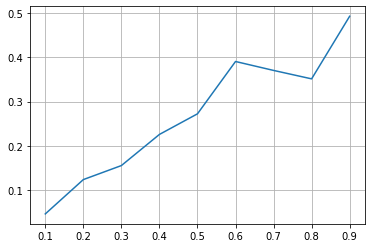

In [84]:
    rmse = []
    r2 = []
    tmp = data_all_copy

    X = tmp.iloc[:,feature_number+3:feature_number+5]
    y = tmp.iloc[:,feature_number:feature_number+1]
    test0 = pd.DataFrame()
    train0 = pd.DataFrame()
    for j in range(9):

      X_train, X_test, y_train, y_test = ks.train_test_split(X, y, test_size = (9-j)/10)
      top_k_idx = X_train.index.tolist()

      data_sampled = tmp.loc[top_k_idx]
      data_minus = tmp.append(data_sampled).drop_duplicates(keep=False)

      train = train0.append(data_sampled)
      test = test0.append(data_minus)
  
      X_test = test.iloc[:,0:feature_number].values
      X_train = train.iloc[:,0:feature_number].values
      y_test = test.iloc[:,feature_number:feature_number+1].values
      y_train = train.iloc[:,feature_number:feature_number+1].values 

      regressor_student = RandomForestRegressor(n_estimators=200,max_features=61)
      regressor_student.fit(X_train, y_train) 

      y_pred = regressor_student.predict(X_test)  

      rmse.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
      r2.append(metrics.r2_score(y_test, y_pred))

    xlabel=np.arange(0.1,1,0.1)
    plt.plot(xlabel,r2)
    plt.grid() 
    plt.show()

In [60]:
test0 = pd.DataFrame()
train0 = pd.DataFrame()

X_train, X_test, y_train, y_test = ks.train_test_split(X, y, test_size = 83/737)
top_k_idx = X_train.index.tolist()

data_sampled = tmp.loc[top_k_idx]
data_minus = tmp.append(data_sampled).drop_duplicates(keep=False)

train = train0.append(data_sampled)
test = test0.append(data_minus)
  
X_test = test.iloc[:,0:feature_number].values
X_train = train.iloc[:,0:feature_number].values
y_test = test.iloc[:,feature_number:feature_number+1].values
y_train = train.iloc[:,feature_number:feature_number+1].values 

regressor_student = RandomForestRegressor(n_estimators=200,max_features=61)
regressor_student.fit(X_train, y_train) 

y_pred = regressor_student.predict(X_test)  
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(metrics.r2_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


19.857562245474544
0.5150291035362233


In [61]:
train = train.reset_index()
del train['index']

In [62]:
feature_number = 3693

In [63]:
train

,ABC_b,ABCGG_b,nBase_b,nAromAtom_b,nAromBond_b,nAtom_b,nHeavyAtom_b,nBridgehead_b,nHetero_b,nH_b,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,yield_dft,type,class,tsne_1,tsne_2
0,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-0.636795,-0.297772,-0.257138,-0.880724,-0.564264,34.869999,eln,I,0.145476,0.715276
1,-0.800886,-0.694898,-0.090536,-1.149697,-1.143310,0.160051,-0.745807,-0.097251,0.527036,0.880815,...,0.998459,1.056905,1.040882,0.133127,0.692751,82.860001,eln,Br,0.525638,0.286717
2,-1.185441,-0.637949,-0.090536,-1.149697,-1.143310,0.064462,-1.129916,-0.097251,-1.203144,1.115720,...,0.180832,-0.749330,-0.813433,2.324353,-0.983269,8.660000,eln,Cl,0.640140,0.615854
3,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.998459,1.056905,1.040882,0.133127,0.692751,21.870001,eln,I,0.260051,0.158122
4,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-0.636795,-0.297772,-0.257138,-0.880724,-0.564264,60.250000,eln,Cl,0.364152,0.639628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,0.924979,0.889639,-0.090536,1.012885,1.077031,0.351231,0.918665,-0.097251,-0.338054,-0.411164,...,0.998459,1.056905,1.040882,0.133127,0.692751,81.000000,eln,Br,0.532180,0.355605
650,0.435007,0.315785,-0.090536,0.472239,0.423990,-0.031128,0.406520,-0.097251,0.527036,-0.411164,...,-0.636795,-0.297772,-0.257138,-0.880724,-0.564264,79.790001,eln,unknown,0.109124,0.456581
651,-0.718316,0.082898,-0.090536,-1.960665,-1.926960,2.167439,-0.489734,-0.097251,0.527036,3.112414,...,-0.636795,-1.652448,-1.740590,0.885339,1.321259,0.000000,eln,Cl,0.852959,0.569852
652,-0.678444,-0.430702,-0.090536,-1.149697,-1.143310,0.829181,-0.617771,-0.097251,-1.203144,1.585530,...,0.998459,1.056905,1.040882,0.133127,0.692751,44.070000,eln,Br,0.500163,0.001032


In [64]:
per_tree_pred = np.array([tree.predict(train.iloc[:,0:feature_number].values) for tree in regressor_student.estimators_])
per_tree_pred_df = pd.DataFrame(per_tree_pred).T
per_tree_pred_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,34.869999,27.669999,36.009999,47.949999,44.349999,22.929999,34.869999,44.349999,61.029999,61.029999,...,39.609999,47.949999,45.789999,23.500000,10.990000,26.909999,41.013999,35.629999,48.519999,22.929999
1,82.860001,86.086667,92.540001,3.920000,0.000000,86.086667,87.700001,84.739998,46.130001,87.700001,...,89.313334,92.540001,86.086667,82.860001,2.000000,92.540001,82.860001,87.700001,87.700001,50.910000
2,8.660000,6.960000,3.550000,6.960000,8.660000,8.660000,6.960000,7.810000,7.810000,8.235000,...,7.640000,7.810000,6.960000,8.235000,8.093333,7.526667,8.660000,16.540001,6.960000,8.660000
3,84.870003,24.262500,21.870001,25.059999,23.996667,21.870001,25.059999,22.508001,0.000000,21.870001,...,25.059999,21.870001,25.059999,25.059999,23.465000,23.465000,25.059999,22.933334,21.870001,23.465000
4,56.880001,28.772500,60.250000,30.376667,58.565001,56.880001,59.126667,22.858000,26.435000,56.880001,...,60.250000,60.250000,56.880001,58.565001,59.126667,56.880001,56.880001,60.250000,59.126667,58.003334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,88.000000,9.150000,81.000000,81.000000,26.750000,81.000000,85.000000,85.000000,81.000000,81.000000,...,73.000000,81.000000,81.000000,98.650002,81.000000,81.000000,81.000000,81.000000,81.000000,8.140000
650,0.000000,79.790001,79.790001,98.309998,92.136665,98.309998,79.790001,85.963333,98.309998,92.136665,...,93.679998,89.049999,89.049999,98.309998,98.309998,89.049999,89.049999,48.020000,83.494000,89.049999
651,0.000000,0.000000,41.470001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.450000,39.169998,0.000000,0.000000,0.000000,22.200001,49.599998,0.000000,0.000000,0.000000
652,49.135000,44.070000,50.823334,49.135000,54.200001,49.135000,49.135000,68.416000,44.070000,48.122000,...,44.070000,44.070000,43.950001,44.070000,54.200001,44.070000,44.070000,49.135000,46.602500,71.639999


In [65]:
rf_result = per_tree_pred_df

In [66]:
rf_result['yield_dft'] = train['yield_dft']
rf_result['type'] = train['type']
rf_result['tsne_1'] = train['tsne_1']
rf_result['tsne_2'] = train['tsne_2']

In [67]:
rf_result

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,yield_dft,type,tsne_1,tsne_2
0,34.869999,27.669999,36.009999,47.949999,44.349999,22.929999,34.869999,44.349999,61.029999,61.029999,...,10.990000,26.909999,41.013999,35.629999,48.519999,22.929999,34.869999,eln,0.145476,0.715276
1,82.860001,86.086667,92.540001,3.920000,0.000000,86.086667,87.700001,84.739998,46.130001,87.700001,...,2.000000,92.540001,82.860001,87.700001,87.700001,50.910000,82.860001,eln,0.525638,0.286717
2,8.660000,6.960000,3.550000,6.960000,8.660000,8.660000,6.960000,7.810000,7.810000,8.235000,...,8.093333,7.526667,8.660000,16.540001,6.960000,8.660000,8.660000,eln,0.640140,0.615854
3,84.870003,24.262500,21.870001,25.059999,23.996667,21.870001,25.059999,22.508001,0.000000,21.870001,...,23.465000,23.465000,25.059999,22.933334,21.870001,23.465000,21.870001,eln,0.260051,0.158122
4,56.880001,28.772500,60.250000,30.376667,58.565001,56.880001,59.126667,22.858000,26.435000,56.880001,...,59.126667,56.880001,56.880001,60.250000,59.126667,58.003334,60.250000,eln,0.364152,0.639628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,88.000000,9.150000,81.000000,81.000000,26.750000,81.000000,85.000000,85.000000,81.000000,81.000000,...,81.000000,81.000000,81.000000,81.000000,81.000000,8.140000,81.000000,eln,0.532180,0.355605
650,0.000000,79.790001,79.790001,98.309998,92.136665,98.309998,79.790001,85.963333,98.309998,92.136665,...,98.309998,89.049999,89.049999,48.020000,83.494000,89.049999,79.790001,eln,0.109124,0.456581
651,0.000000,0.000000,41.470001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,22.200001,49.599998,0.000000,0.000000,0.000000,0.000000,eln,0.852959,0.569852
652,49.135000,44.070000,50.823334,49.135000,54.200001,49.135000,49.135000,68.416000,44.070000,48.122000,...,54.200001,44.070000,44.070000,49.135000,46.602500,71.639999,44.070000,eln,0.500163,0.001032


In [68]:
#data_all = pd.concat([data.iloc[:,0:120],rf_result],axis=1)
train_all = rf_result

In [69]:
feature_num = 200

In [70]:
test = test.reset_index()
del test['index']

In [71]:
per_tree_pred = np.array([tree.predict(test.iloc[:,0:feature_number].values) for tree in regressor_student.estimators_])
per_tree_pred_df = pd.DataFrame(per_tree_pred).T
per_tree_pred_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,75.070000,0.000000,75.070000,75.070000,75.070000,75.070000,0.000000,56.410000,5.280000,75.070000,...,73.349998,81.800003,75.070000,75.070000,75.070000,75.070000,75.070000,75.070000,75.070000,43.230000
1,75.070000,0.000000,75.070000,75.070000,75.070000,75.070000,0.000000,56.410000,5.280000,75.070000,...,73.349998,81.800003,75.070000,75.070000,75.070000,75.070000,75.070000,75.070000,75.070000,43.230000
2,46.320000,76.029999,76.029999,61.576667,61.174999,71.480000,56.223333,58.203999,62.380001,76.029999,...,58.686000,50.820000,46.320000,56.223333,58.203999,46.320000,57.762500,65.190000,69.205000,62.380001
3,54.490000,50.706000,54.490000,50.706000,59.549999,45.965000,49.430000,45.965000,45.965000,42.500000,...,49.430000,51.025000,42.500000,50.227500,48.495000,50.493333,13.270000,59.549999,48.183333,51.025000
4,39.070000,39.070000,39.070000,47.949999,44.349999,39.070000,0.000000,32.060001,45.639999,32.060001,...,39.070000,39.070000,39.070000,0.000000,48.990002,43.765001,32.450001,32.060001,39.070000,39.070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,57.730000,51.709999,51.709999,0.000000,51.480000,51.709999,59.099998,22.858000,2.000000,51.709999,...,0.000000,3.030000,51.709999,51.480000,10.780000,51.709999,51.709999,51.709999,51.709999,51.709999
79,0.000000,5.510000,42.340000,12.780000,12.780000,28.353333,12.780000,42.820000,64.599998,5.510000,...,12.780000,0.000000,12.780000,12.780000,12.780000,12.780000,33.240002,33.240002,0.000000,12.780000
80,50.770000,36.000000,99.360001,36.000000,56.410000,36.000000,36.000000,36.000000,67.458001,79.510002,...,80.019997,36.000000,36.000000,90.519997,90.519997,36.000000,36.000000,36.000000,38.790001,85.000000
81,39.250000,98.459999,58.410000,39.250000,57.110001,40.757500,39.250000,39.250000,39.250000,39.250000,...,100.279999,0.000000,84.870003,39.250000,39.250000,39.250000,39.250000,39.250000,79.839996,39.250000


In [72]:
rf_result = per_tree_pred_df
rf_result['yield_dft'] = test['yield_dft']
rf_result['type'] = test['type']
rf_result['tsne_1'] = test['tsne_1']
rf_result['tsne_2'] = test['tsne_2']

In [73]:
test_all = rf_result

In [74]:
test_all

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,yield_dft,type,tsne_1,tsne_2
0,75.070000,0.000000,75.070000,75.070000,75.070000,75.070000,0.000000,56.410000,5.280000,75.070000,...,75.070000,75.070000,75.070000,75.070000,75.070000,43.230000,57.470001,eln,0.074117,0.198797
1,75.070000,0.000000,75.070000,75.070000,75.070000,75.070000,0.000000,56.410000,5.280000,75.070000,...,75.070000,75.070000,75.070000,75.070000,75.070000,43.230000,65.430000,eln,0.074115,0.198797
2,46.320000,76.029999,76.029999,61.576667,61.174999,71.480000,56.223333,58.203999,62.380001,76.029999,...,58.203999,46.320000,57.762500,65.190000,69.205000,62.380001,40.860001,eln,0.629178,0.706020
3,54.490000,50.706000,54.490000,50.706000,59.549999,45.965000,49.430000,45.965000,45.965000,42.500000,...,48.495000,50.493333,13.270000,59.549999,48.183333,51.025000,63.330002,eln,0.132155,0.726707
4,39.070000,39.070000,39.070000,47.949999,44.349999,39.070000,0.000000,32.060001,45.639999,32.060001,...,48.990002,43.765001,32.450001,32.060001,39.070000,39.070000,69.180000,eln,0.153659,0.724501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,57.730000,51.709999,51.709999,0.000000,51.480000,51.709999,59.099998,22.858000,2.000000,51.709999,...,10.780000,51.709999,51.709999,51.709999,51.709999,51.709999,55.349998,eln,0.333958,0.677707
79,0.000000,5.510000,42.340000,12.780000,12.780000,28.353333,12.780000,42.820000,64.599998,5.510000,...,12.780000,12.780000,33.240002,33.240002,0.000000,12.780000,29.320000,eln,0.726386,0.643057
80,50.770000,36.000000,99.360001,36.000000,56.410000,36.000000,36.000000,36.000000,67.458001,79.510002,...,90.519997,36.000000,36.000000,36.000000,38.790001,85.000000,60.000000,eln,0.483786,0.290006
81,39.250000,98.459999,58.410000,39.250000,57.110001,40.757500,39.250000,39.250000,39.250000,39.250000,...,39.250000,39.250000,39.250000,39.250000,79.839996,39.250000,54.349998,eln,0.224310,0.182143
